## Test Kepert 2025

TODO: For now without z_ref nor h, add them.

TODO: There is a mistake in Eq. 29 of Kepert, I didn't try to correct it.

TODO: Correct the prime components, which are not expressed in the paper, I would need to compute them myself. Hopefully for Larry I don't need them because I alsways have I > V / r.

TODO: If I take c1 = c2 = 0, I still have an asymmetry in the reconstructed field... Weird.

Good cases (wind directions):
Dora (ep2023) is really a nice case study
rcm1-sc50ma-owi-ca-20200812t014959-20200812t015243-00003-______sw_ep092020_cyclone_polar
rcm1-sclnd-owi-ca-20230809t050027-20230809t050143-00003-______sw_ep052023_cyclone_polar
rcm1-sclnd-owi-ca-20230829t235046-20230829t235203-00003-______sw_al102023_cyclone_polar

Try to reproduce Fig. 5 of Kepert's 2025 model

<u>Conclusion</u>: I still need to correct the code of the Kepert's 2025 model, and check by comparing with his figures, but my feeling is that the resulting wind fields are much more asymmetric, with the asymmetry decreasing with r outside Rmax. This could compare well with the SAR observations except than in the observations, the asymmetry decreases only for r > 2Rmax. 

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    # 'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [4]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = psi(Rs, Vs, K, C, fcor)
    ki_1 = eta(Rs, Vs, K, C, fcor)
    # New expressions
    num = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = psi(Rs, Vs, K, C, fcor)
    ki_1 = eta(Rs, Vs, K, C, fcor)
    # New expressions
    num = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

# def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
#     num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
#     den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
#     return num / den

# def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
#     num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
#     den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
#     return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    '''TODO: Update but I need to compute the terms myself (not in the paper)'''
    return A1(Rs, Vs, K, C, c1, c2, fcor)

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    '''TODO: Update but I need to compute the terms myself (not in the paper)'''
    return A_1(Rs, Vs, K, C, c1, c2, fcor)

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z) + u0(Rs, Vs, K, C, fcor, z) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, z)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z) + v0(Rs, Vs, K, C, fcor, z) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, z)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, z):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z)
    v_K01   = v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
def get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, c1, c2, fcr):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2025(THs, Rs, Vs, K, C, c1, c2, fcr, z) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

def get_w_Ekman(Rs, rs, Vs, K, C, fcr):
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try = Vs / wrf
    dr     = rs[1] - rs[0] # meters
    num    = rs * C * Vs_try[0, :] * (Vs_try[0, :] + 2 * Vs[0, :])
    den    = fcr + Vs_try[0, :] / rs + np.gradient(Vs_try[0, :], dr)
    return (1 / rs) *  np.gradient(num / den, dr)

In [6]:
# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [32]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
zs           = np.array([0])
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset
xs           = np.linspace(1000, 250000, 250)

# BL characteristics
C  = 1.5e-3
K  = 50
c1 = 0.0
# c2 = 0.2
c2 = 0.0

# Ks = [10, 20, 30, 40, 50, 100, 150] # trial
# Ks = [100]

### Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}
# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

### Test on single file

In [33]:
### Open file
file_tcva = 's1b-ew-owi-ca-20210907t214630-20210907t215005-000003-0369AB_sw_al122021_cyclone_polar.nc' # Larry
# file_tcva = 'rcm2-sc100ma-owi-ca-20210818t143906-20210818t144138-00003-______sw_ep122021_cyclone_polar.nc' # Linda
ds        = dsg.where(dsg.file_tcva == file_tcva, drop=True)
# Optional
dsp       = xr.open_dataset(PTHS['sar_dir'] + file_tcva).isel(time=0)

In [34]:
# Fixed parameters
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [35]:
### Dependance on z
kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, c1, c2, fcr)

  0%|          | 0/1 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/1 [00:00<?, ?it/s]

Cartesian dataset created.


In [36]:
# kep_car.wind_speed.plot(cmap=cwnd, norm=normalizer)

In [37]:
LWS      = [] # To save the Holland wind speeds
ACN_HOL1 = [] # Amplitude of cosine using Holland - WN1
ACN1     = [] # WN1
for th in th_steps:
    ds_slice          = kep_pol.sel(z=0).sel(theta=slice(th, th + th_delta))
    wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, float(abs(ds.lat)), B, Vmin, Rmax, Vmax), 
            np.array(wsm.rad), 
            np.array(wsm), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    # Append
    LWS.append(holland_profile(rs, float(abs(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
# Create dataset structure
dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)
# Compute Asymmetries
for rad in xs:
    # WN1 - Holland
    acn_hol1, phi_hol1, c_hol1 = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').th), dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').ws, 5., float(ds.vmx))
    ACN_HOL1.append(acn_hol1)
    # WN1 - Only to debug
    acn1, phi1, c1             = get_wn1(np.deg2rad(kep_pol.sel(z=0, rad=rad).theta), kep_pol.sel(z=0, rad=rad).wind_speed, 5., float(ds.vmx))
    ACN1.append(acn1)

(0.0, 6.0)

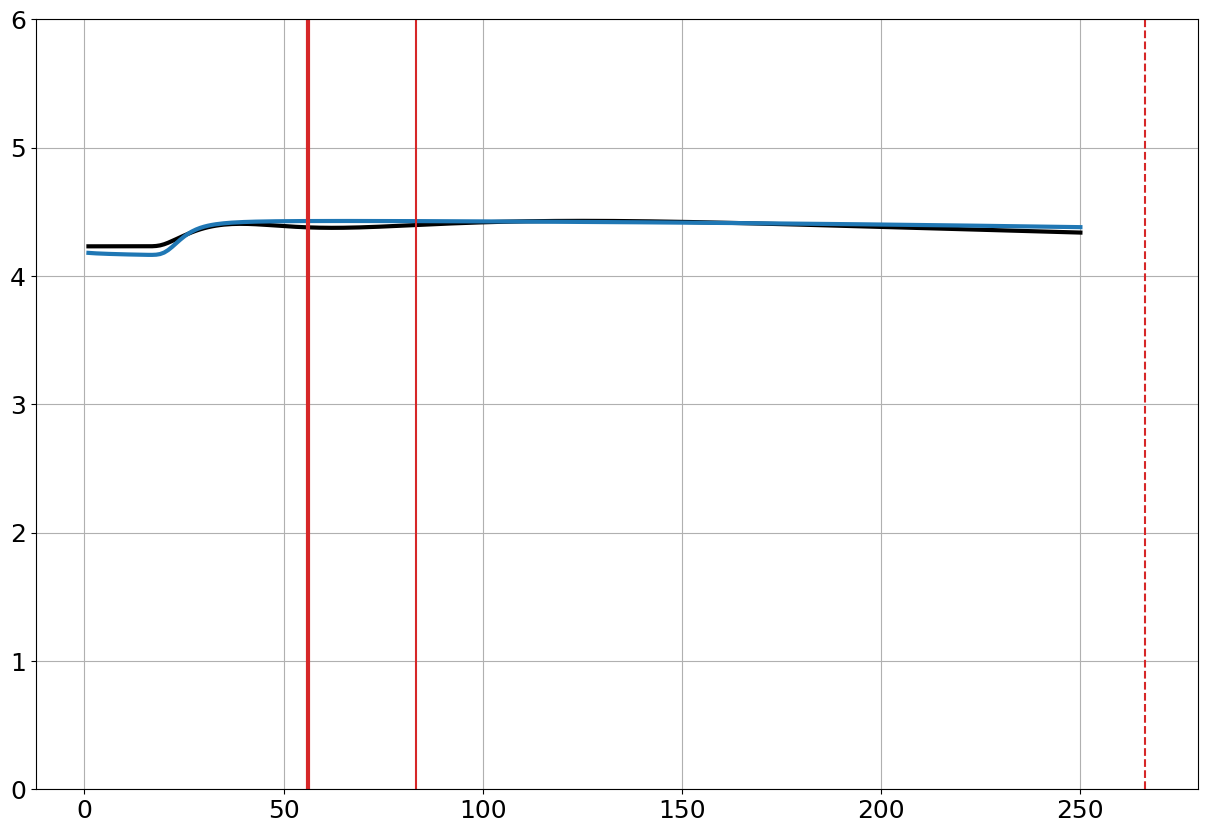

In [38]:
plt.plot(xs / 1000, ACN_HOL1, c='k',        linewidth=3, label='Amplitude of cosine using Holland - WN1')
plt.plot(xs / 1000, ACN1,     c='tab:blue', linewidth=3, label='Amplitude of cosine - WN1')
# Wind radii
plt.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
plt.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
plt.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')
plt.grid()
plt.ylim(0, 6)

(0.0, 150000.0)

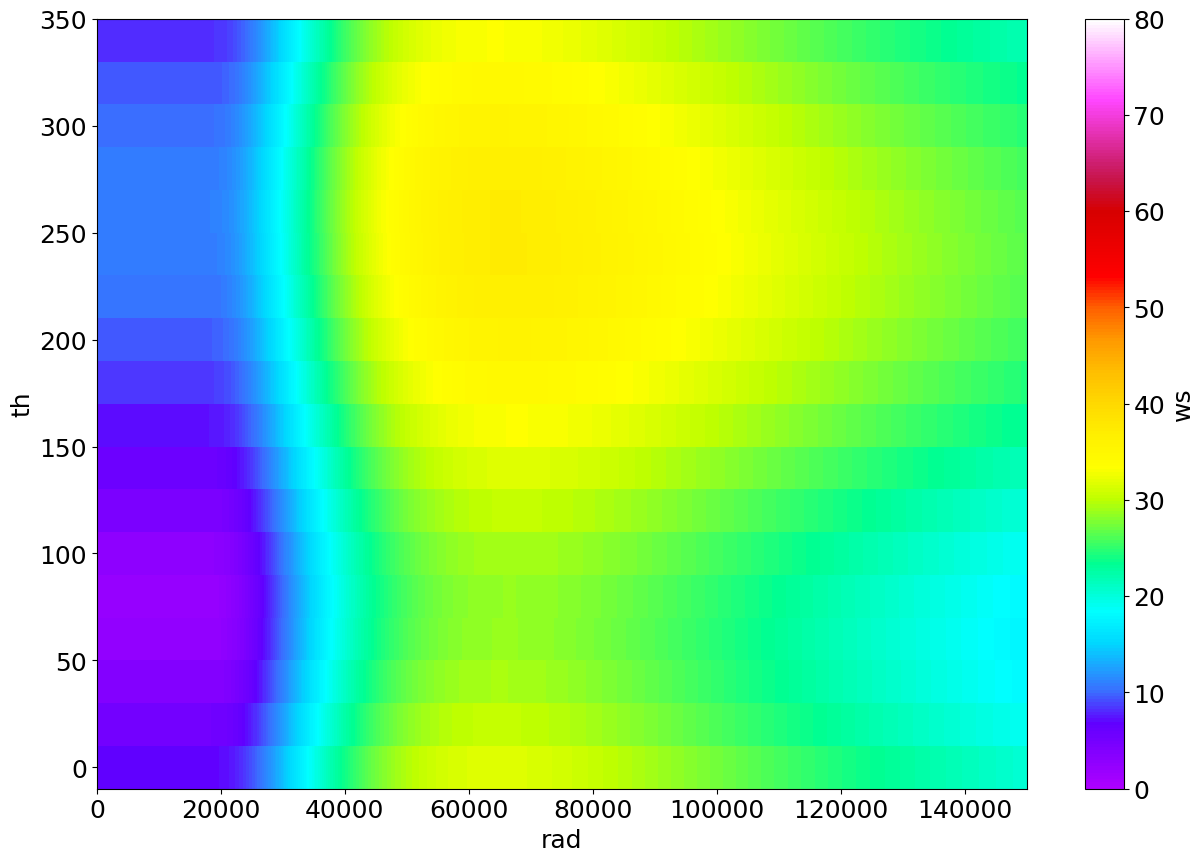

In [39]:
dsh.ws.plot(cmap=cwnd, norm=normalizer)
plt.xlim(0, 150000)

(0.0, 150000.0)

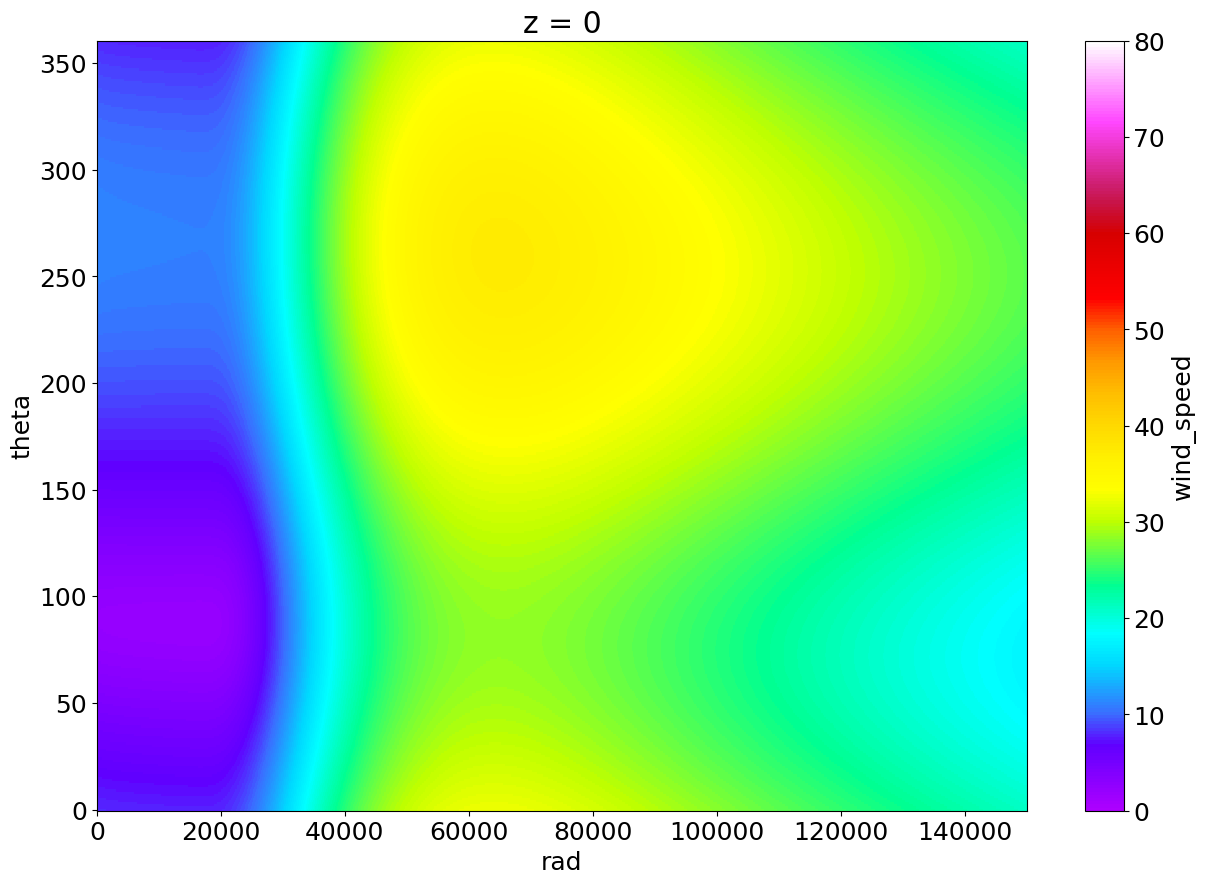

In [40]:
kep_pol.sel(z=0).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.xlim(0, 150000)

(0.0, 150000.0)

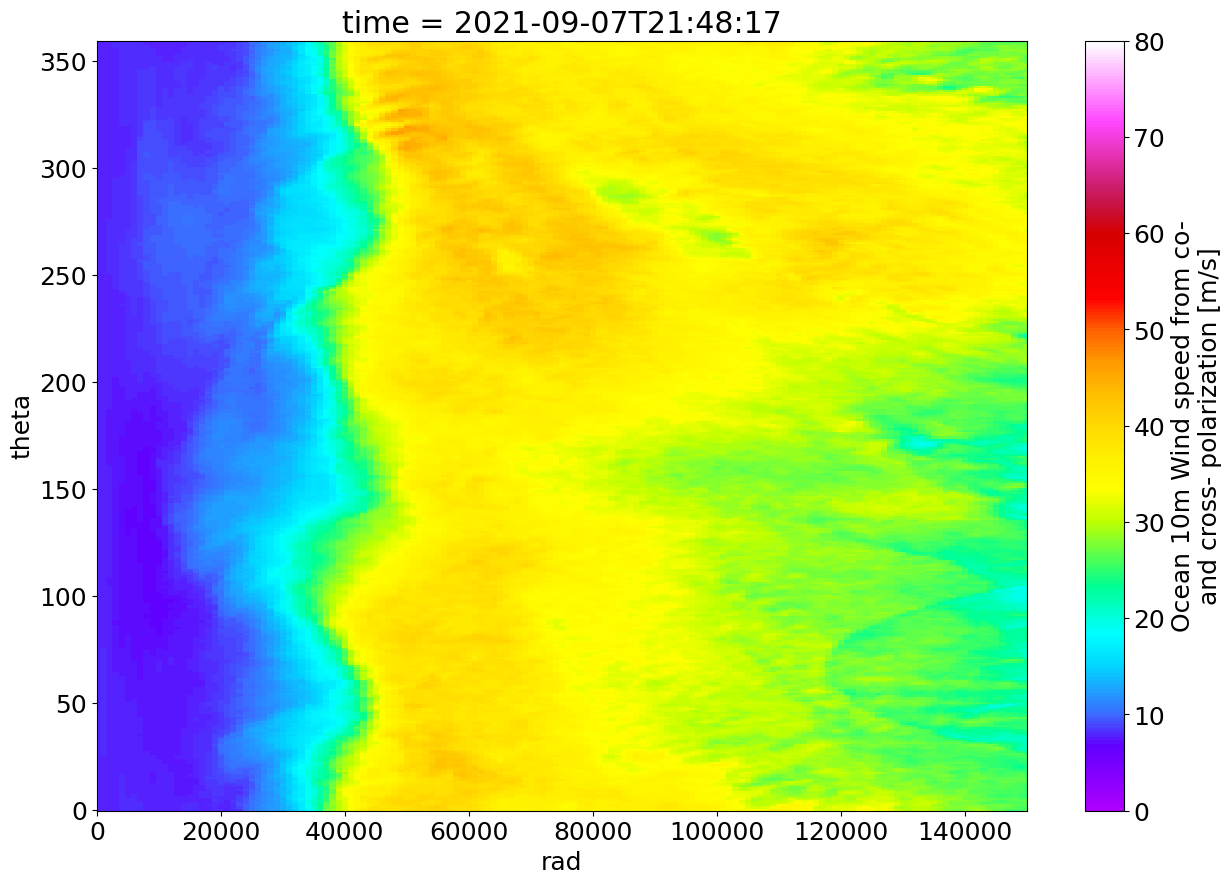

In [41]:
dsp.wind_speed.transpose().plot(cmap=cwnd, norm=normalizer)
plt.xlim(0, 150000)

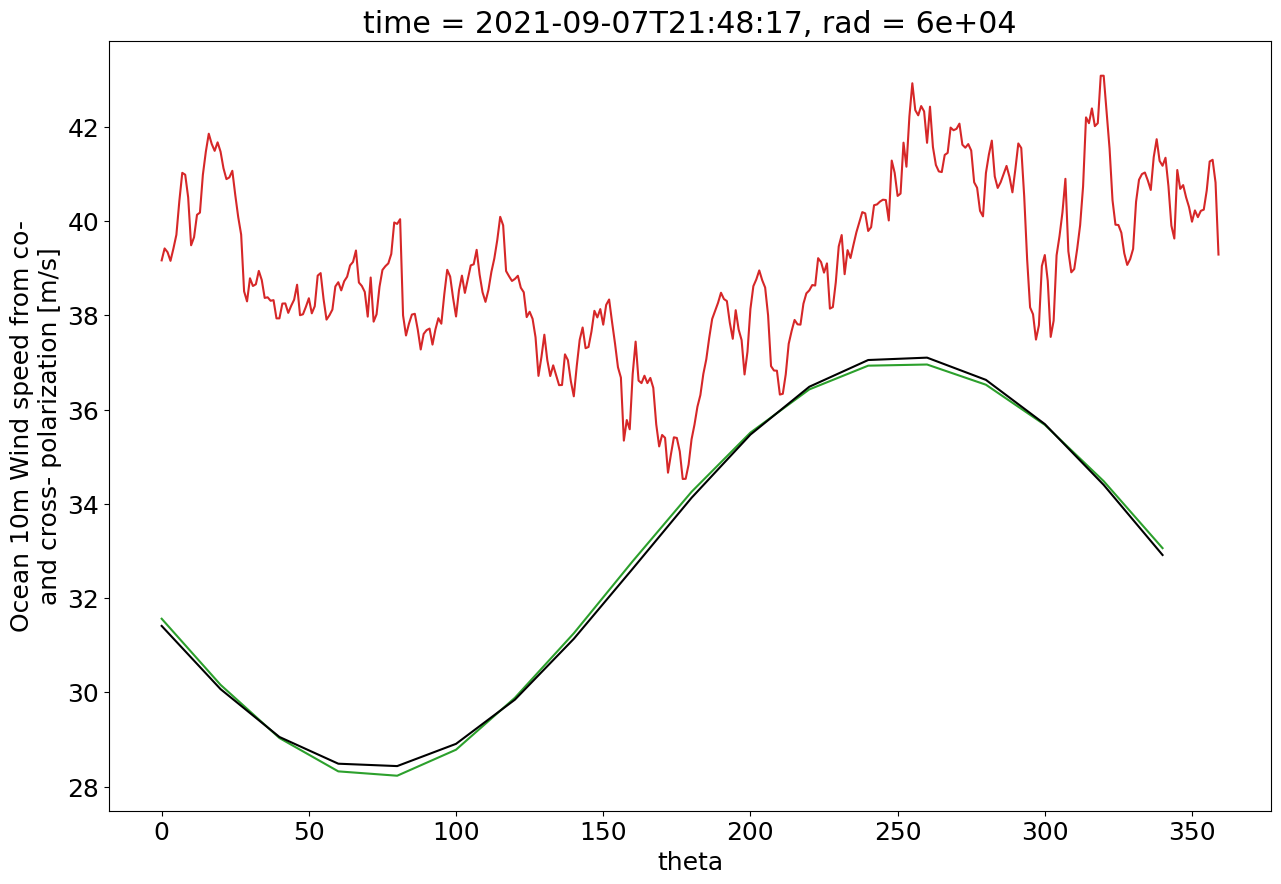

In [42]:
### INVESTIGATE
# Sel
rad = 60000
dsh_test = dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th')
# Fit
acn_hol1, phi_hol1, c_hol1 = get_wn1(np.deg2rad(dsh_test.th), dsh_test.ws, 5., float(ds.vmx))

# Plot
dsh_test.ws.plot(c='tab:green')
plt.plot(np.array(dsh_test.th), wn1(np.deg2rad(dsh_test.th), acn_hol1, phi_hol1, c_hol1),    c='k')
dsp.sel(rad=rad).wind_speed.plot(c='tab:red')

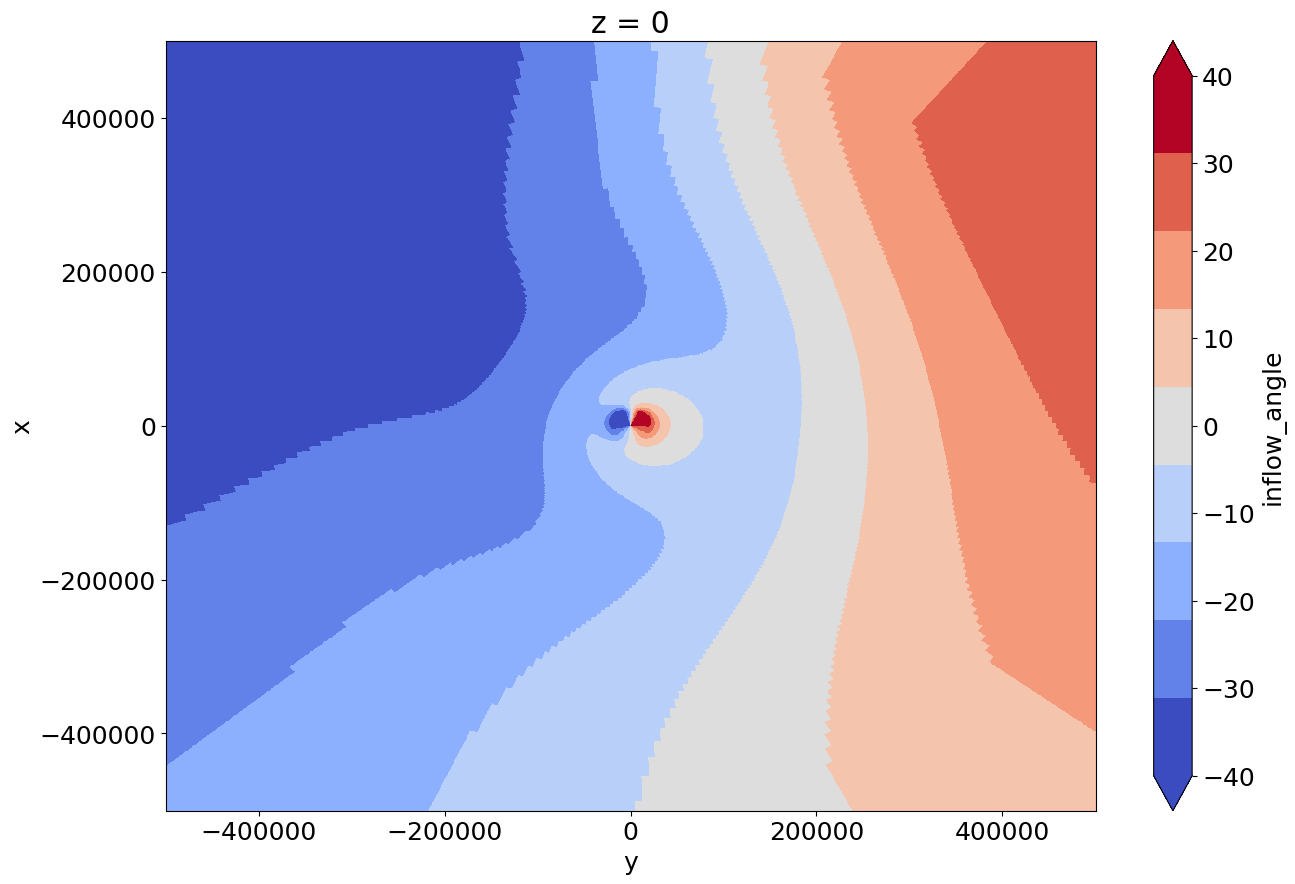

In [43]:
kep_car.sel(z=0).inflow_angle.plot(cmap=plt.get_cmap('coolwarm', 9), vmin=-40, vmax=40)

### Composite

In [88]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 33) & 
    (dsg.dist2coast > dsg.r34)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

343


In [89]:
# Fixed parameters
vmx = float(d.vmx_hol.mean())
rmx = float(d.rmx_hol.mean())
vmn = float(d.vmn_hol.mean())
B   = float(d.B_hol.mean())
lat = float(abs(d.lat).mean())
fcr = float(abs(d.fcor.mean()))
Ut  = float(d.speed.mean())

# Holland with fixed parameters
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [90]:
### Dependance on z
kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, c1, c2, fcr)

  0%|          | 0/1 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/1 [00:00<?, ?it/s]

Cartesian dataset created.


In [91]:
LWS      = [] # To save the Holland wind speeds
ACN_HOL1 = [] # Amplitude of cosine using Holland - WN1
ACN1     = [] # WN1
for th in th_steps:
    ds_slice          = kep_pol.sel(z=0).sel(theta=slice(th, th + th_delta))
    wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, float(abs(ds.lat)), B, Vmin, Rmax, Vmax), 
            np.array(wsm.rad), 
            np.array(wsm), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    # Append
    LWS.append(holland_profile(rs, float(abs(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
# Create dataset structure
dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)
# Compute Asymmetries
for rad in xs:
    # WN1 - Holland
    acn_hol1, phi_hol1, c_hol1 = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').th), dsh.sel(rad=rad, method='nearest').dropna(subset=['ws'], dim='th').ws, 5., float(ds.vmx))
    ACN_HOL1.append(acn_hol1)
    # WN1 - Only to debug
    acn1, phi1, c1             = get_wn1(np.deg2rad(kep_pol.sel(z=0, rad=rad).theta), kep_pol.sel(z=0, rad=rad).wind_speed, 5., float(ds.vmx))
    ACN1.append(acn1)

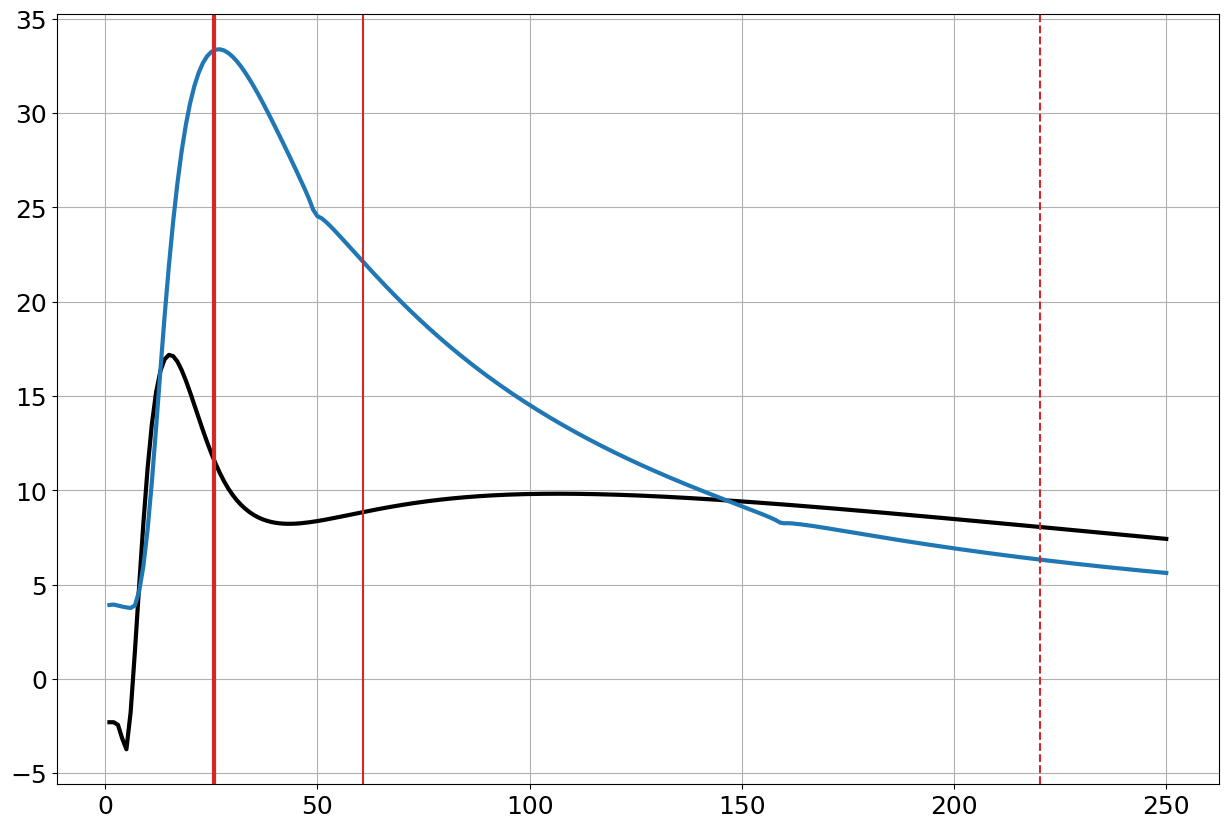

In [92]:
plt.plot(xs / 1000, np.array(ACN_HOL1) - Ut, c='k',        linewidth=3, label='Amplitude of cosine using Holland - WN1')
plt.plot(xs / 1000, np.array(ACN1) - Ut,     c='tab:blue', linewidth=3, label='Amplitude of cosine using Holland - WN1')
# Wind radii
plt.axvline(d.rmx.mean() / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
plt.axvline(d.rps.mean() / 1000,                      c='tab:red',                        label='R+')
plt.axvline(d.r0.mean()  / 1000,                      c='tab:red',    linestyle='dashed', label='R0')
plt.grid()